<a href="https://colab.research.google.com/github/Agniva2006/Implmenting-Blip-From-Scratch-on-mnist-dataset/blob/main/blip_from_scratch_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision tqdm pillow pycocotools matplotlib git+https://github.com/salaniz/pycocoevalcap


  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-g5jrs8tc
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-g5jrs8tc
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=15ca529f2d7328df3335b668501db56cc5feed02d697b4c6f3715a142dce30fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq2wny3o/wheels/03/ce/0b/3d3fdeecb09b4f4ebcfb3ff28d27a9f5b3c1a7b73897ad122d
Successfully built pycocoevalcap


In [2]:
import os, json, random, math
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
import os
from pathlib import Path

# Base directory for COCO dataset
coco_dir = Path("/content/coco")
img_dir = coco_dir / "train2017"
ann_dir = coco_dir / "annotations"

# Create folders
os.makedirs(img_dir, exist_ok=True)
os.makedirs(ann_dir, exist_ok=True)

# Download COCO 2017 captions annotation
if not (ann_dir / "captions_train2017.json").exists():
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/
    !unzip -q /content/annotations_trainval2017.zip -d /content/coco/
    print(" COCO captions annotations downloaded and extracted!")

# Download COCO train images
if not any(img_dir.iterdir()):
    print(" Downloading COCO 2017 train images (~18GB)... This can take a while.")
    !wget http://images.cocodataset.org/zips/train2017.zip -P /content/
    !unzip -q /content/train2017.zip -d /content/coco/
    print(" COCO train images extracted!")

print("COCO dataset setup complete!")


--2025-12-27 07:08:32--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.202.180, 54.231.230.129, 52.217.170.201, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.202.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.9MB/s    in 17s     

2025-12-27 07:08:50 (14.2 MB/s) - ‘/content/annotations_trainval2017.zip’ saved [252907541/252907541]

 COCO captions annotations downloaded and extracted!
--2025-12-27 07:09:03--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.179.222, 52.216.48.81, 16.15.185.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.179.222|:80... connected.
HTTP request sent, awaiting response... 200

In [4]:
from PIL import Image
import torch
import os
from transformers import AutoTokenizer
import json

class CocoCaptionsDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_path, tokenizer_name="bert-base-uncased", transform=None, max_images=None):
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Load annotations
        with open(ann_path, 'r') as f:
            data = json.load(f)

        # Map image_id -> filename
        self.image_map = {img['id']: img['file_name'] for img in data['images']}

        # Keep only first max_images images (if specified)
        if max_images:
            first_ids = sorted(self.image_map.keys())[:max_images]
            self.annotations = [ann for ann in data['annotations'] if ann['image_id'] in first_ids]
            self.image_map = {k:v for k,v in self.image_map.items() if k in first_ids}
        else:
            self.annotations = data['annotations']

        # Filter annotations whose images actually exist
        self.annotations = [ann for ann in self.annotations
                            if os.path.exists(os.path.join(self.img_dir, self.image_map[ann['image_id']]))]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_id = ann['image_id']
        img_name = self.image_map[img_id]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = ann['caption']
        tokens = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=40,
            return_tensors='pt'
        )

        return image, tokens["input_ids"].squeeze(0), tokens["attention_mask"].squeeze(0)


In [5]:
# Paths
IMG_DIR = "/content/coco/train2017"
ANN_PATH = "/content/coco/annotations/captions_train2017.json"

# Dataset init
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = CocoCaptionsDataset(
    img_dir=IMG_DIR,
    ann_path=ANN_PATH,
    transform=transform,
    max_images=10000)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=512):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_ch, embed_dim, patch_size, patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1,2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads=heads; self.head_dim=dim//heads
        self.qkv=nn.Linear(dim,dim*3); self.proj=nn.Linear(dim,dim)
    def forward(self,x):
        B,N,D=x.shape
        qkv=self.qkv(x).reshape(B,N,3,self.heads,self.head_dim).permute(2,0,3,1,4)
        q,k,v=qkv
        attn=(q@k.transpose(-2,-1))/math.sqrt(self.head_dim)
        attn=attn.softmax(dim=-1)
        out=(attn@v).transpose(1,2).reshape(B,N,D)
        return self.proj(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1=nn.LayerNorm(dim)
        self.attn=MultiHeadSelfAttention(dim,heads)
        self.norm2=nn.LayerNorm(dim)
        self.mlp=nn.Sequential(nn.Linear(dim,int(dim*mlp_ratio)),nn.GELU(),
                               nn.Linear(int(dim*mlp_ratio),dim))
    def forward(self,x):
        x=x+self.attn(self.norm1(x))
        x=x+self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self,img_size=224,patch=16,embed_dim=512,depth=6,heads=8):
        super().__init__()
        self.patch=PatchEmbedding(img_size,patch,3,embed_dim)
        self.cls=nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos=nn.Parameter(torch.randn(1,1+self.patch.n_patches,embed_dim))
        self.blocks=nn.Sequential(*[TransformerBlock(embed_dim,heads) for _ in range(depth)])
        self.norm=nn.LayerNorm(embed_dim)
    def forward(self,x):
        B=x.size(0)
        x=self.patch(x)
        cls=self.cls.expand(B,-1,-1)
        x=torch.cat([cls,x],1)
        x=x+self.pos[:,:x.size(1)]
        x=self.blocks(x)
        return self.norm(x)[:,0]


In [7]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads=heads; self.head_dim=dim//heads
        self.qkv=nn.Linear(dim,dim*3); self.proj=nn.Linear(dim,dim)
    def forward(self,x):
        B,N,D=x.shape
        qkv=self.qkv(x).reshape(B,N,3,self.heads,self.head_dim).permute(2,0,3,1,4)
        q,k,v=qkv
        attn=(q@k.transpose(-2,-1))/math.sqrt(self.head_dim)
        attn=attn.softmax(-1)
        out=(attn@v).transpose(1,2).reshape(B,N,D)
        return self.proj(out)

class CrossAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads=heads; self.head_dim=dim//heads
        self.q=nn.Linear(dim,dim); self.kv=nn.Linear(dim,dim*2); self.proj=nn.Linear(dim,dim)
    def forward(self,q_in,kv_in):
        B,Nq,D=q_in.shape; Nk=kv_in.size(1)
        q=self.q(q_in).reshape(B,Nq,self.heads,self.head_dim).permute(0,2,1,3)
        kv=self.kv(kv_in).reshape(B,Nk,2,self.heads,self.head_dim).permute(2,0,3,1,4)
        k,v=kv
        attn=(q@k.transpose(-2,-1))/math.sqrt(self.head_dim)
        attn=attn.softmax(-1)
        out=(attn@v).transpose(1,2).reshape(B,Nq,D)
        return self.proj(out)

class EncoderLayer(nn.Module):
    def __init__(self,dim,heads):
        super().__init__()
        self.norm1=nn.LayerNorm(dim); self.attn=SelfAttention(dim,heads)
        self.norm2=nn.LayerNorm(dim); self.ff=nn.Sequential(nn.Linear(dim,dim*4),nn.GELU(),nn.Linear(dim*4,dim))
    def forward(self,x):
        x=x+self.attn(self.norm1(x)); x=x+self.ff(self.norm2(x)); return x

class DecoderLayer(nn.Module):
    def __init__(self,dim,heads):
        super().__init__()
        self.self_attn=SelfAttention(dim,heads)
        self.cross=CrossAttention(dim,heads)
        self.norm1=nn.LayerNorm(dim); self.norm2=nn.LayerNorm(dim); self.norm3=nn.LayerNorm(dim)
        self.ff=nn.Sequential(nn.Linear(dim,dim*4),nn.GELU(),nn.Linear(dim*4,dim))
    def forward(self,x,mem):
        x=x+self.self_attn(self.norm1(x))
        x=x+self.cross(self.norm2(x),mem)
        x=x+self.ff(self.norm3(x))
        return x

class TextTransformer(nn.Module):
    def __init__(self,vocab,dim=512,depth=4,heads=8,max_len=40):
        super().__init__()
        self.embed=nn.Embedding(vocab,dim)
        self.pos=nn.Parameter(torch.randn(1,max_len,dim))
        self.enc=nn.Sequential(*[EncoderLayer(dim,heads) for _ in range(depth)])
        # Modify the decoder to be a ModuleList instead of Sequential
        self.dec=nn.ModuleList([DecoderLayer(dim,heads) for _ in range(depth)])
        self.norm=nn.LayerNorm(dim)
        self.fc=nn.Linear(dim,vocab)
    def forward(self,src,tgt):
        src=self.embed(src)+self.pos[:,:src.size(1)]
        mem=self.enc(src)
        tgt=self.embed(tgt)+self.pos[:,:tgt.size(1)]
        # Manually iterate through decoder layers
        out = tgt
        for layer in self.dec:
            out = layer(out, mem)
        return self.fc(self.norm(out)), mem

In [8]:
class BLIP(nn.Module):
    def __init__(self,vocab,dim=512):
        super().__init__()
        self.vit=VisionTransformer(embed_dim=dim)
        self.txt=TextTransformer(vocab,dim)
        self.img_proj=nn.Linear(dim,dim)
        self.txt_proj=nn.Linear(dim,dim)
        self.temp=nn.Parameter(torch.tensor(0.07))
    def forward(self,img,src,tgt):
        img_feat=self.img_proj(self.vit(img))
        txt_out, mem=self.txt(src,tgt)
        txt_feat=self.txt_proj(mem[:,0])
        img_feat=F.normalize(img_feat,dim=-1)
        txt_feat=F.normalize(txt_feat,dim=-1)
        logits=(img_feat@txt_feat.t())/self.temp
        return logits, txt_out

def blip_loss(logits,txt_out,tgt):
    labels=torch.arange(len(logits)).to(logits.device)
    ce=nn.CrossEntropyLoss(ignore_index=0)
    itc=(ce(logits,labels)+ce(logits.t(),labels))/2
    lm=ce(txt_out.reshape(-1,txt_out.size(-1)),tgt.reshape(-1))
    return itc+lm


In [9]:

loader=DataLoader(dataset,batch_size=8,shuffle=True,num_workers=2)

vocab_size=30522  # from bert-base-uncased
device="cuda" if torch.cuda.is_available() else "cpu"

model=BLIP(vocab_size).to(device)
opt=torch.optim.AdamW(model.parameters(),lr=5e-5)




In [10]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch_idx, (img, src, mask) in enumerate(tqdm(loader)):
        img, src, mask = img.to(device), src.to(device), mask.to(device)
        logits, txt_out = model(img, src, src)
        loss = blip_loss(logits, txt_out, src)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: avg loss {total_loss/len(loader):.4f}")

100%|██████████| 6254/6254 [13:16<00:00,  7.85it/s]


Epoch 1: avg loss 2.6180


100%|██████████| 6254/6254 [13:18<00:00,  7.83it/s]


Epoch 2: avg loss 2.0624


100%|██████████| 6254/6254 [13:45<00:00,  7.57it/s]

Epoch 3: avg loss 1.8655


In [11]:
!pip install gradio
import gradio as gr
from PIL import Image

In [12]:
from transformers import AutoTokenizer

# Use the same tokenizer as training
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

device = "cuda" if torch.cuda.is_available() else "cpu"

# Ensure your trained model is loaded
model = model.to(device)
model.eval()

BLIP(
  (vit): VisionTransformer(
    (patch): PatchEmbedding(
      (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): Sequential(
      (0): TransformerBlock(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadSelfAttention(
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (1): TransformerBlock(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadSelfAttention(
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj): Linear(in_features=512

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import gradio as gr
import numpy as np
import torch


In [14]:
def generate_caption(model, image_tensor, tokenizer, max_len=40, device="cuda"):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        BOS = tokenizer.cls_token_id
        EOS = tokenizer.sep_token_id

        # Encode image ONCE (conditioning learned during training)
        _ = model.img_proj(model.vit(image_tensor))

        # Start decoding
        input_ids = torch.tensor([[BOS]], dtype=torch.long, device=device)

        for _ in range(max_len):
            logits, _ = model.txt(input_ids, input_ids)  # ONLY tokens
            next_token = logits[:, -1].argmax(-1, keepdim=True)

            input_ids = torch.cat([input_ids, next_token], dim=1)

            if next_token.item() == EOS:
                break

        return tokenizer.decode(input_ids[0], skip_special_tokens=True)

In [17]:
def infer_caption_from_dataset(idx):
    img, tokens, _ = dataset[idx]

    pred = generate_caption(model, img, tokenizer, device=device)
    gt_caption = tokenizer.decode(tokens, skip_special_tokens=True)

    return img, pred, gt_caption


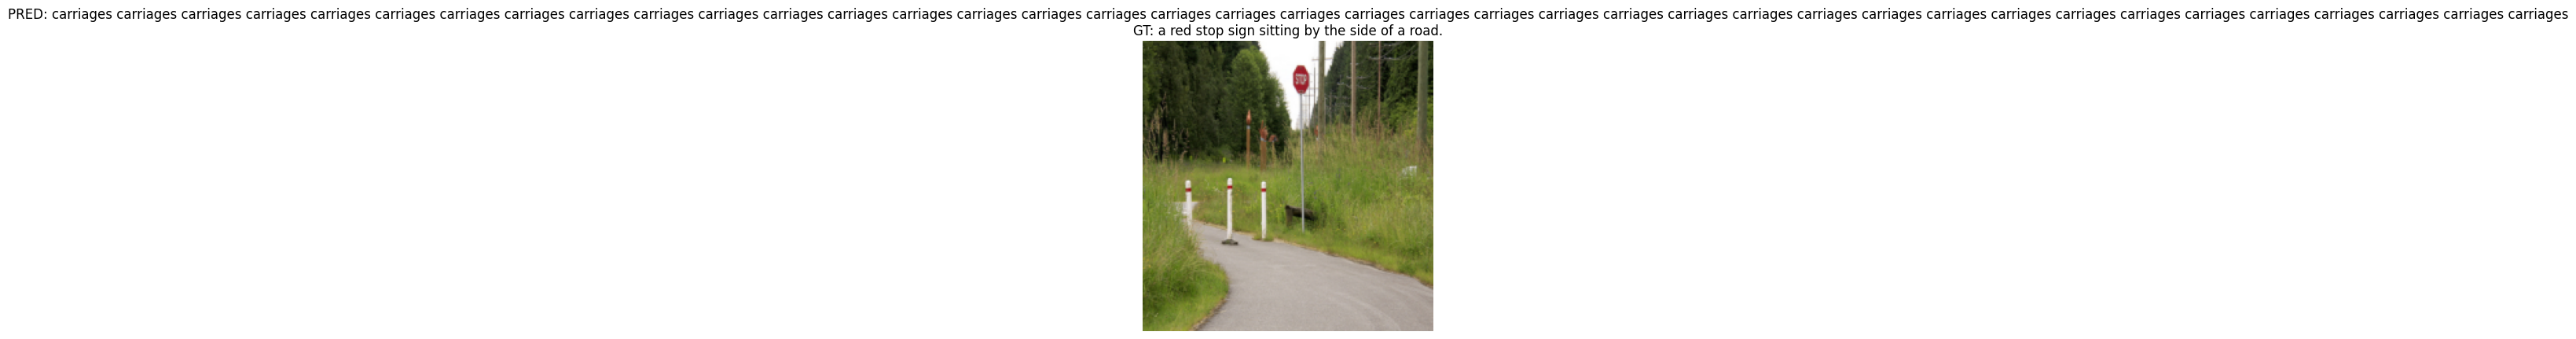

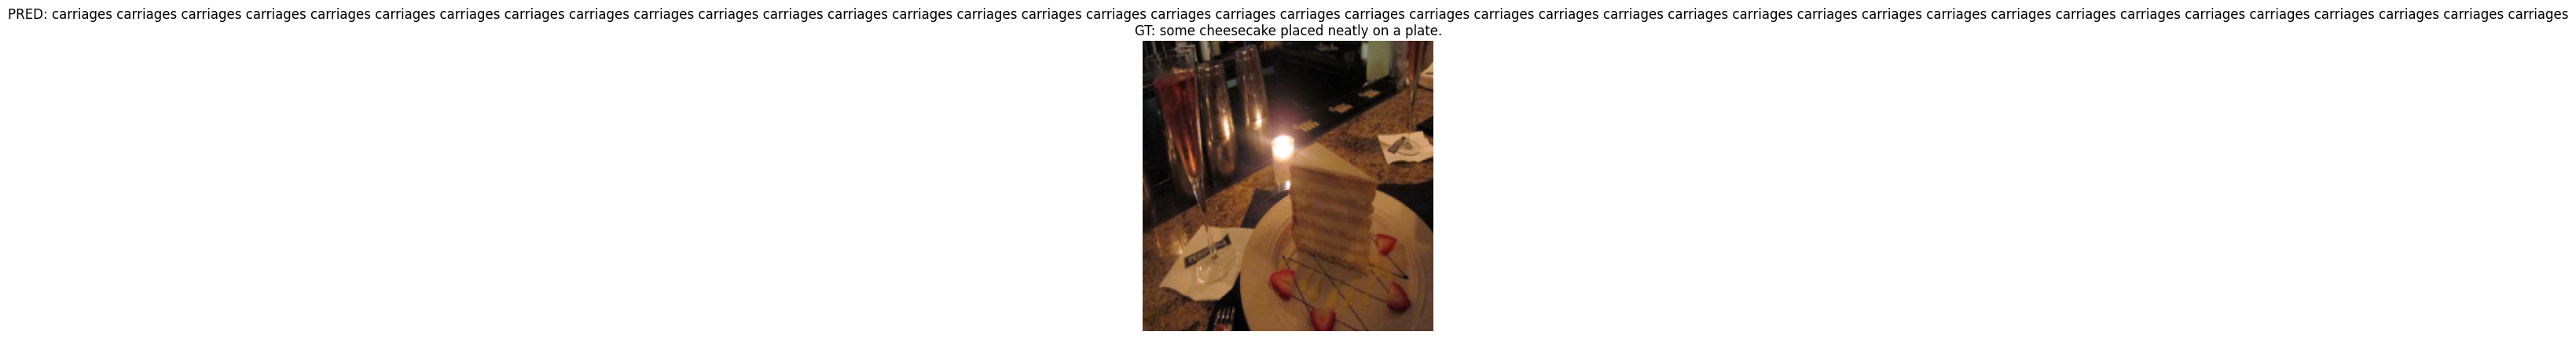

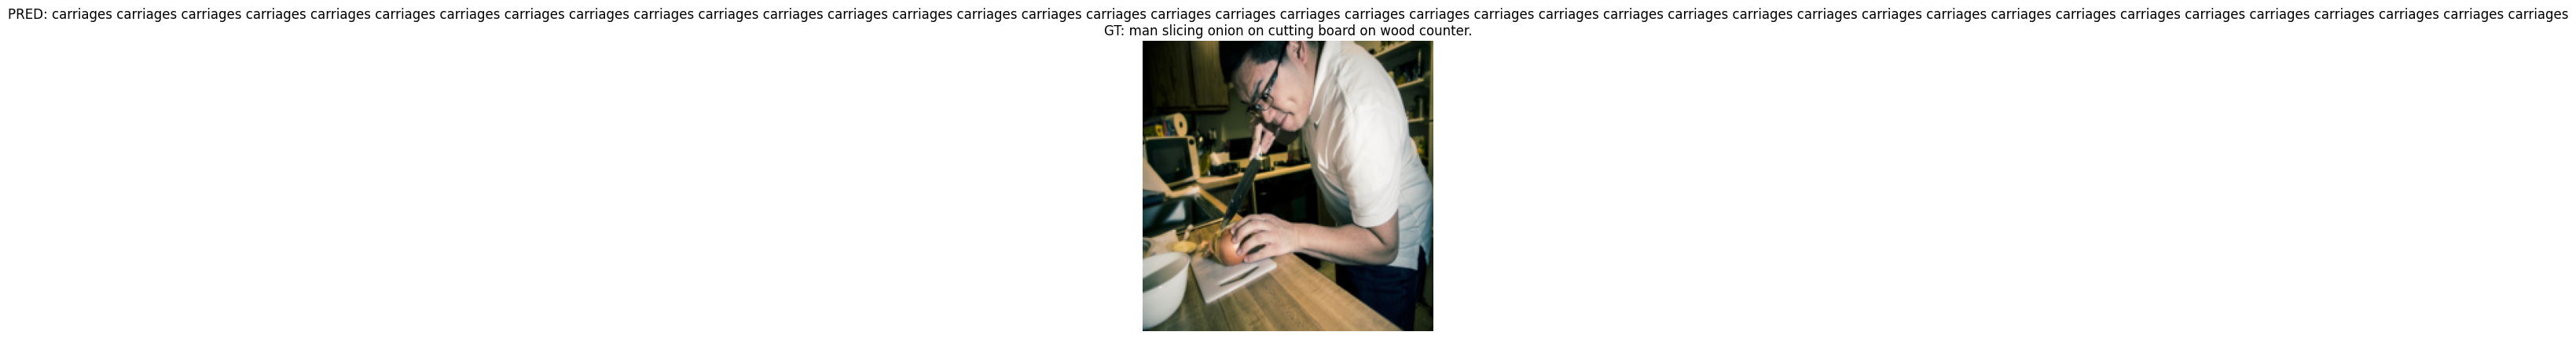

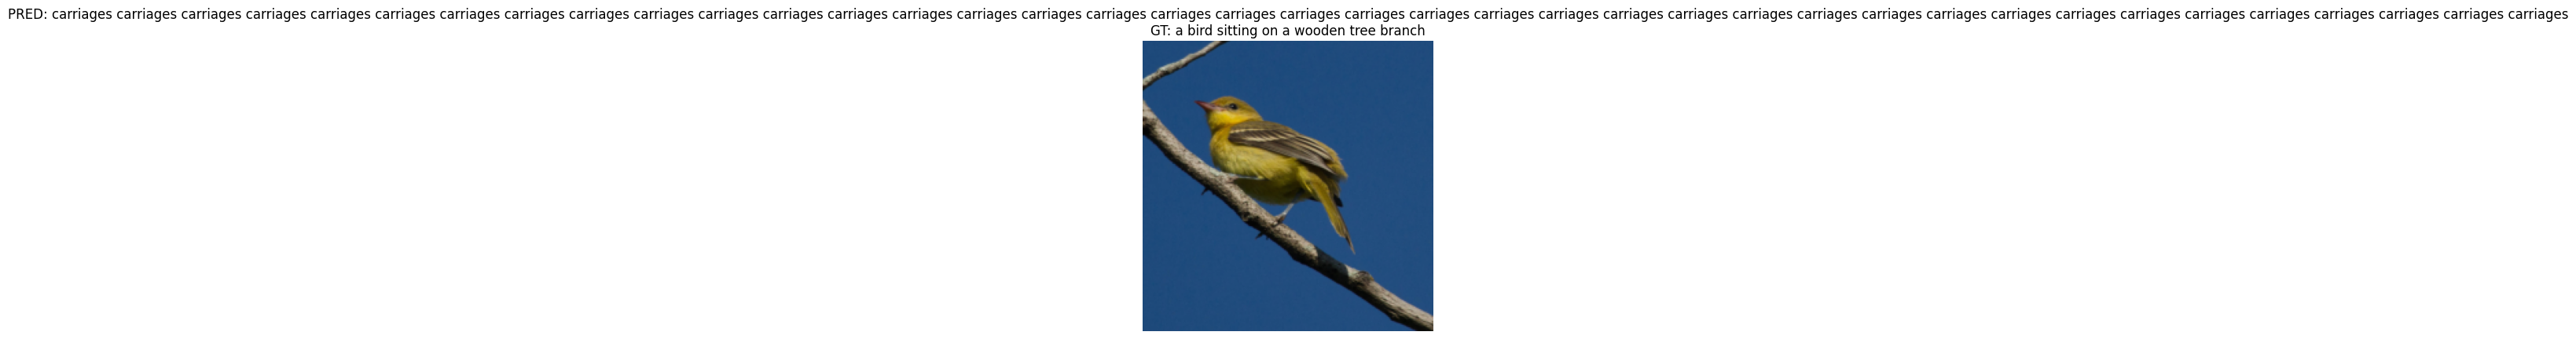

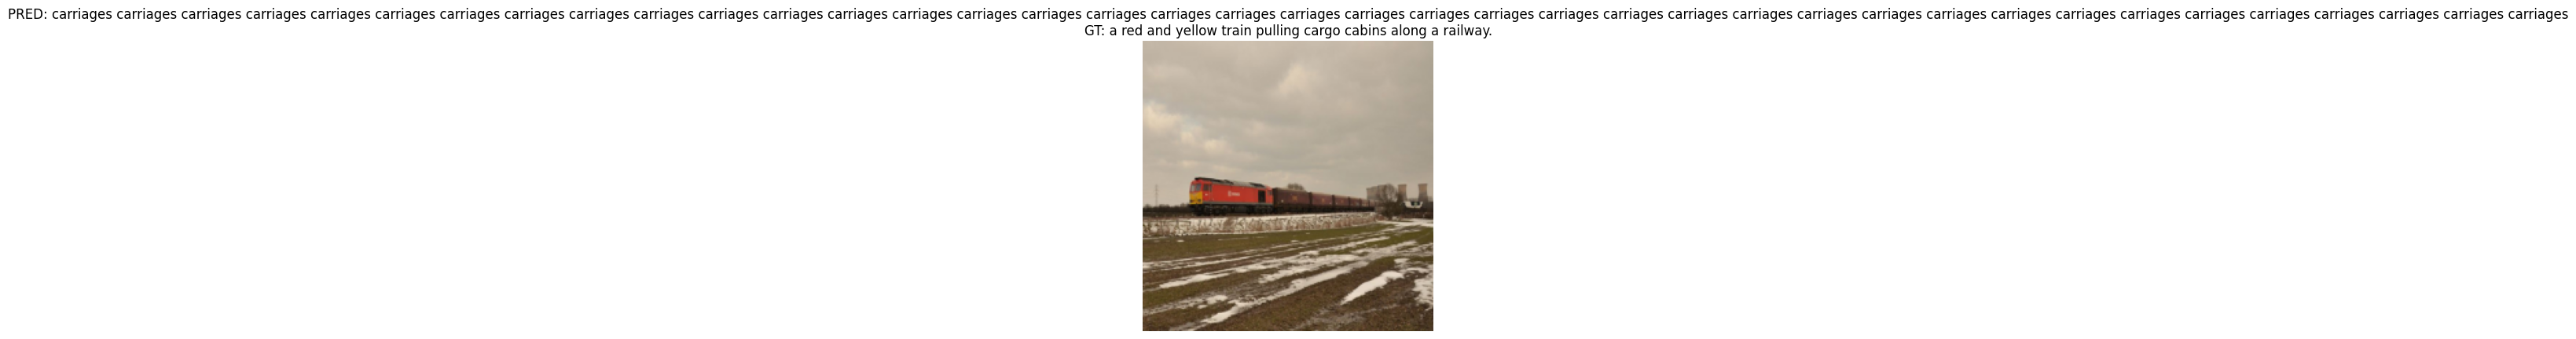

In [18]:
import random
import matplotlib.pyplot as plt

indices = random.sample(range(len(dataset)), 5)

for idx in indices:
    img, pred, gt = infer_caption_from_dataset(idx)

    plt.imshow(img.permute(1,2,0))
    plt.axis("off")
    plt.title(f"PRED: {pred}\nGT: {gt}")
    plt.show()

In [19]:
from PIL import Image
import numpy as np

def infer_caption(img):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img.astype('uint8')).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    caption = generate_caption(model, img_tensor, tokenizer)
    return caption


In [20]:
def generate_caption_beam(
    model,
    image_tensor,
    tokenizer,
    beam_size=3,
    max_len=40,
    device="cuda"
):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    BOS = tokenizer.cls_token_id
    EOS = tokenizer.sep_token_id

    with torch.no_grad():
        # Encode image ONCE (conditioning learned in weights)
        _ = model.img_proj(model.vit(image_tensor))

        # Each beam = (tokens, log_prob)
        beams = [(torch.tensor([[BOS]], device=device), 0.0)]

        for _ in range(max_len):
            new_beams = []

            for tokens, score in beams:
                logits, _ = model.txt(tokens, tokens)
                log_probs = F.log_softmax(logits[:, -1], dim=-1)

                topk_probs, topk_ids = torch.topk(log_probs, beam_size)

                for i in range(beam_size):
                    next_token = topk_ids[:, i].unsqueeze(1)
                    new_tokens = torch.cat([tokens, next_token], dim=1)
                    new_score = score + topk_probs[:, i].item()
                    new_beams.append((new_tokens, new_score))

            # Keep best beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            # Stop early if all beams ended
            if all(b[0][0, -1].item() == EOS for b in beams):
                break

        best_tokens = beams[0][0]
        return tokenizer.decode(best_tokens[0], skip_special_tokens=True)


In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download("punkt")

smooth = SmoothingFunction().method4

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
def evaluate_bleu(
    model,
    dataset,
    tokenizer,
    num_samples=200,
    beam=True
):
    bleu1_scores = []
    bleu4_scores = []

    indices = random.sample(range(len(dataset)), num_samples)

    for idx in tqdm(indices):
        img, tokens, _ = dataset[idx]
        gt_caption = tokenizer.decode(tokens, skip_special_tokens=True)
        gt_tokens = gt_caption.split()

        if beam:
            pred_caption = generate_caption_beam(model, img, tokenizer)
        else:
            pred_caption = generate_caption(model, img, tokenizer)

        pred_tokens = pred_caption.split()

        bleu1 = sentence_bleu(
            [gt_tokens], pred_tokens,
            weights=(1, 0, 0, 0),
            smoothing_function=smooth
        )
        bleu4 = sentence_bleu(
            [gt_tokens], pred_tokens,
            weights=(0.25, 0.25, 0.25, 0.25),
            smoothing_function=smooth
        )

        bleu1_scores.append(bleu1)
        bleu4_scores.append(bleu4)

    print(f"BLEU-1: {sum(bleu1_scores)/len(bleu1_scores):.4f}")
    print(f"BLEU-4: {sum(bleu4_scores)/len(bleu4_scores):.4f}")


In [23]:
evaluate_bleu(model, dataset, tokenizer, num_samples=200, beam=True)


100%|██████████| 200/200 [02:39<00:00,  1.26it/s]

BLEU-1: 0.0000
BLEU-4: 0.0000


In [24]:
def show_samples(model, dataset, tokenizer, num_samples=5, beam=True):
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img, tokens, _ = dataset[idx]
        gt = tokenizer.decode(tokens, skip_special_tokens=True)

        if beam:
            pred = generate_caption_beam(model, img, tokenizer)
        else:
            pred = generate_caption(model, img, tokenizer)

        plt.figure(figsize=(6,6))
        plt.imshow(img.permute(1,2,0))
        plt.axis("off")
        plt.title(f"PRED: {pred}\nGT: {gt}")
        plt.show()


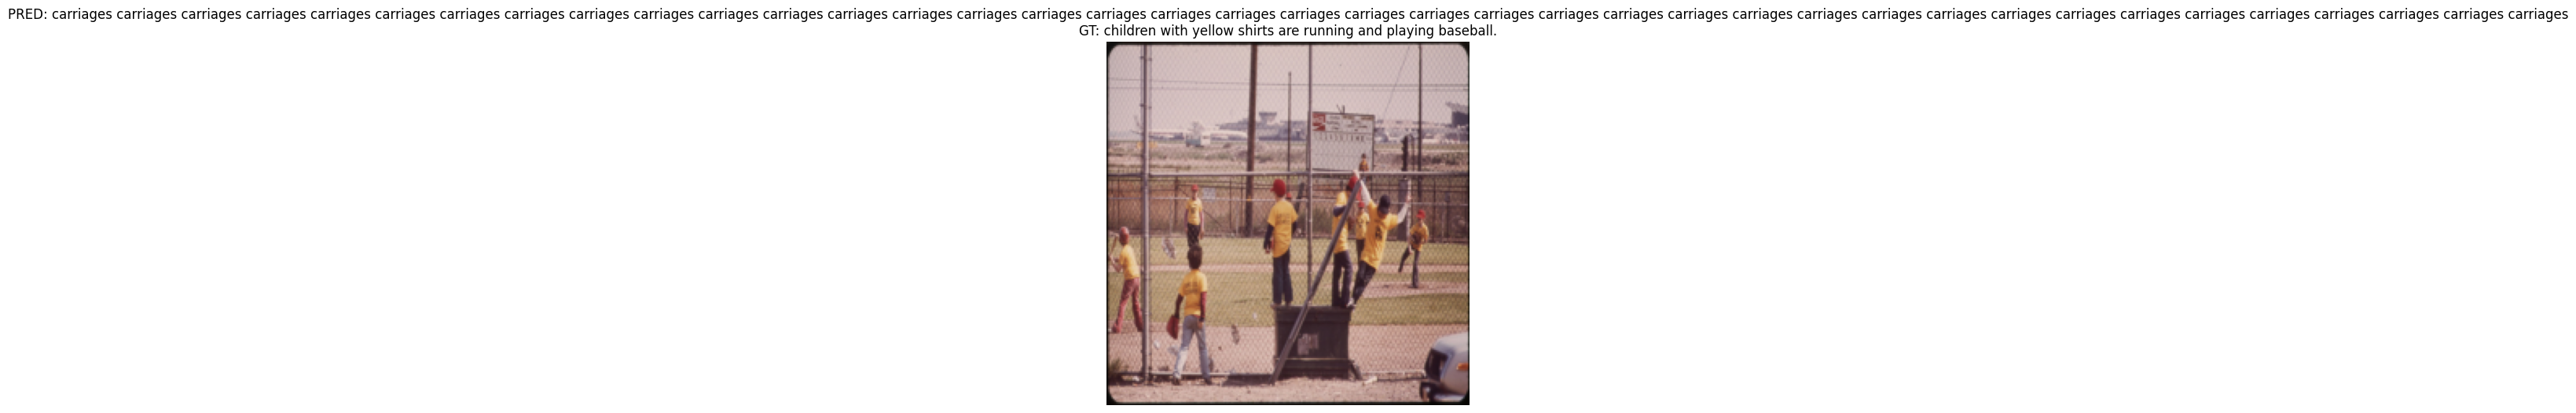

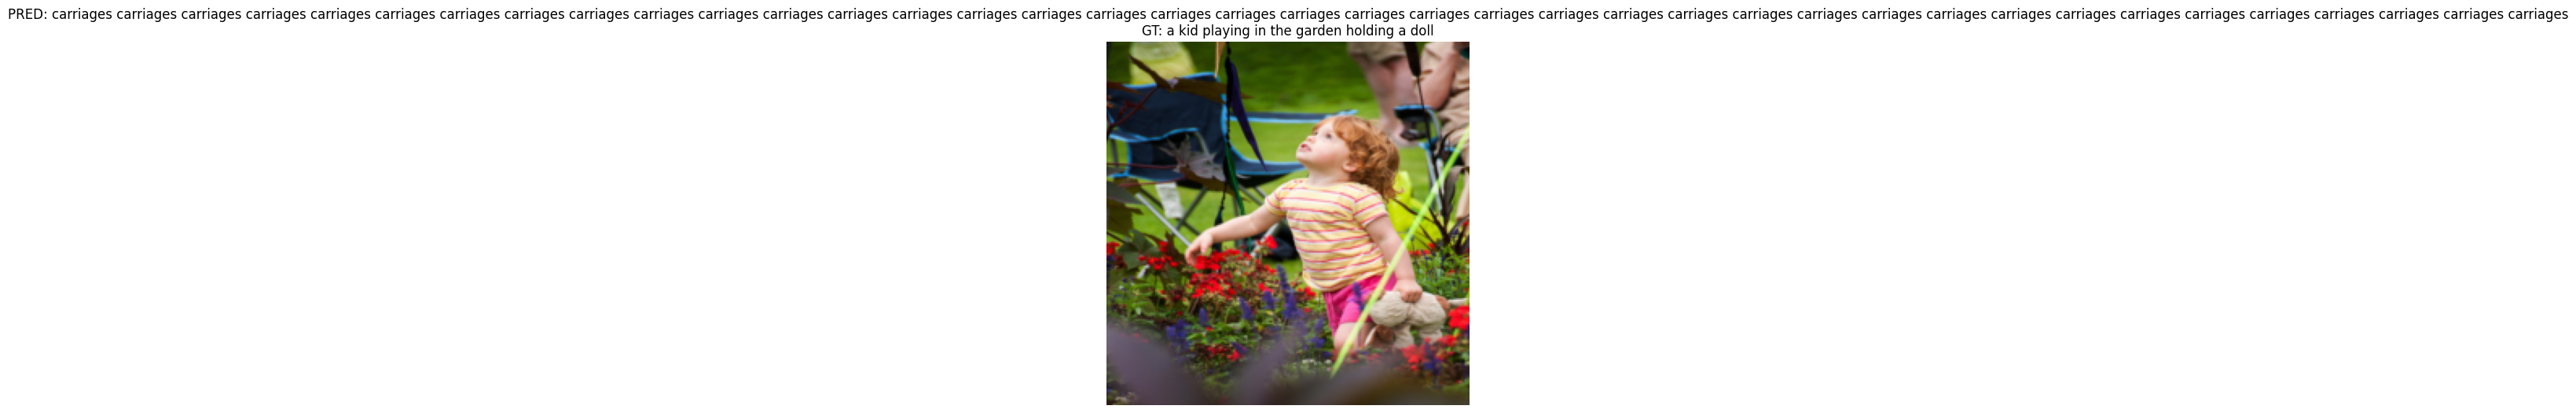

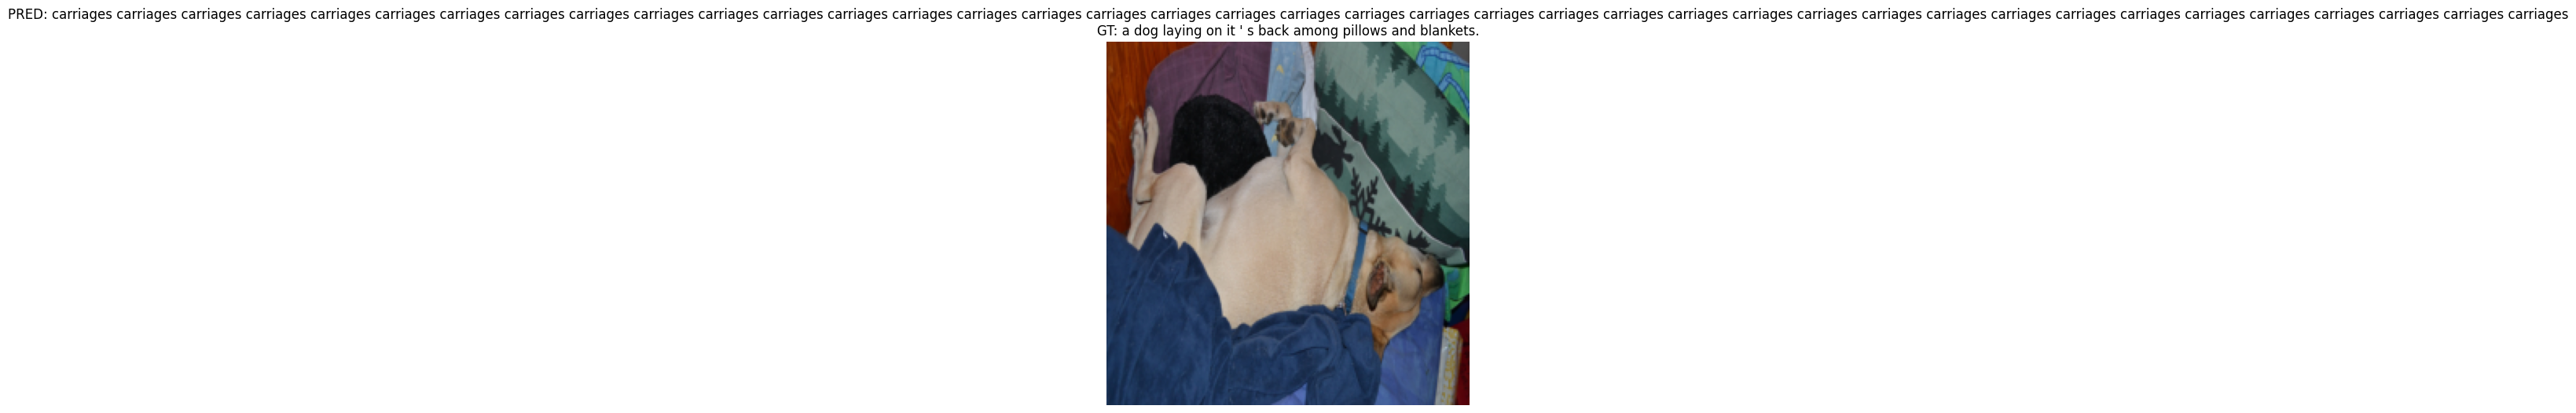

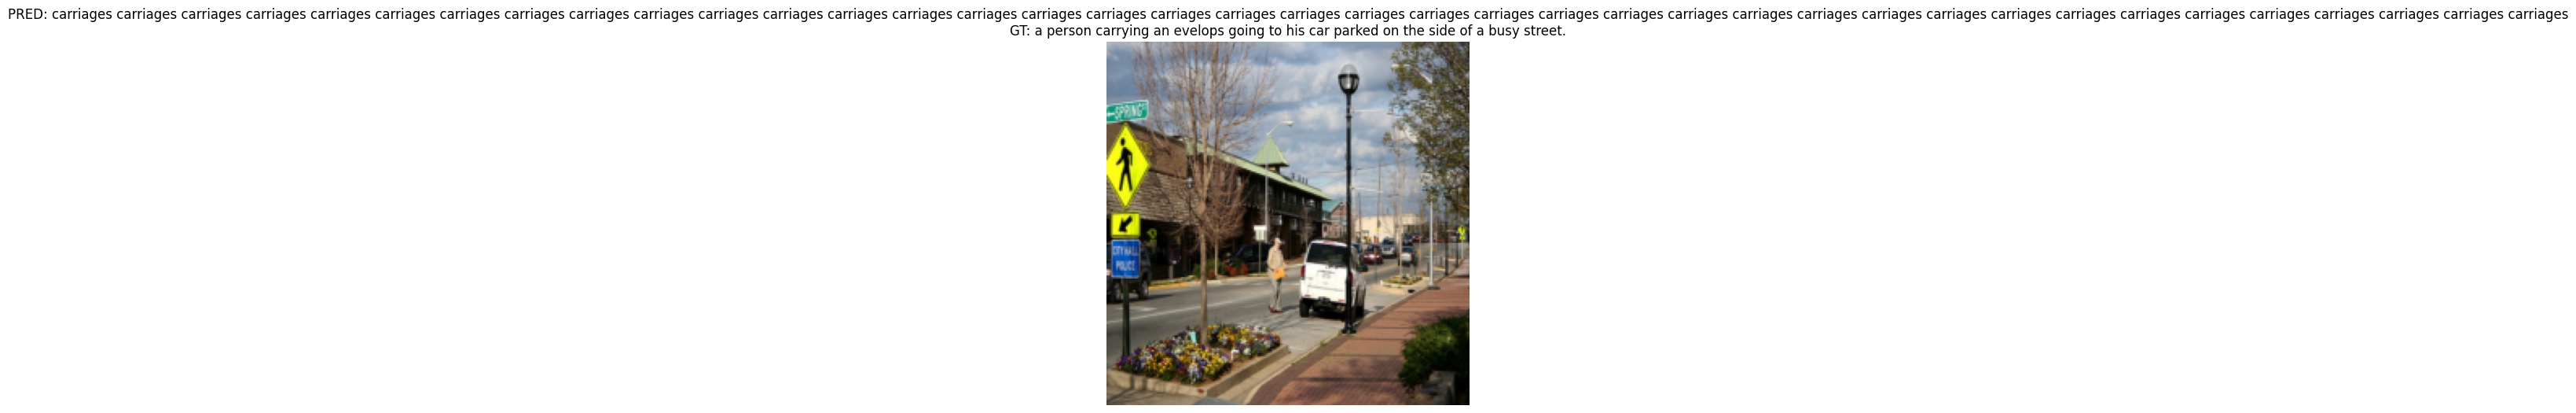

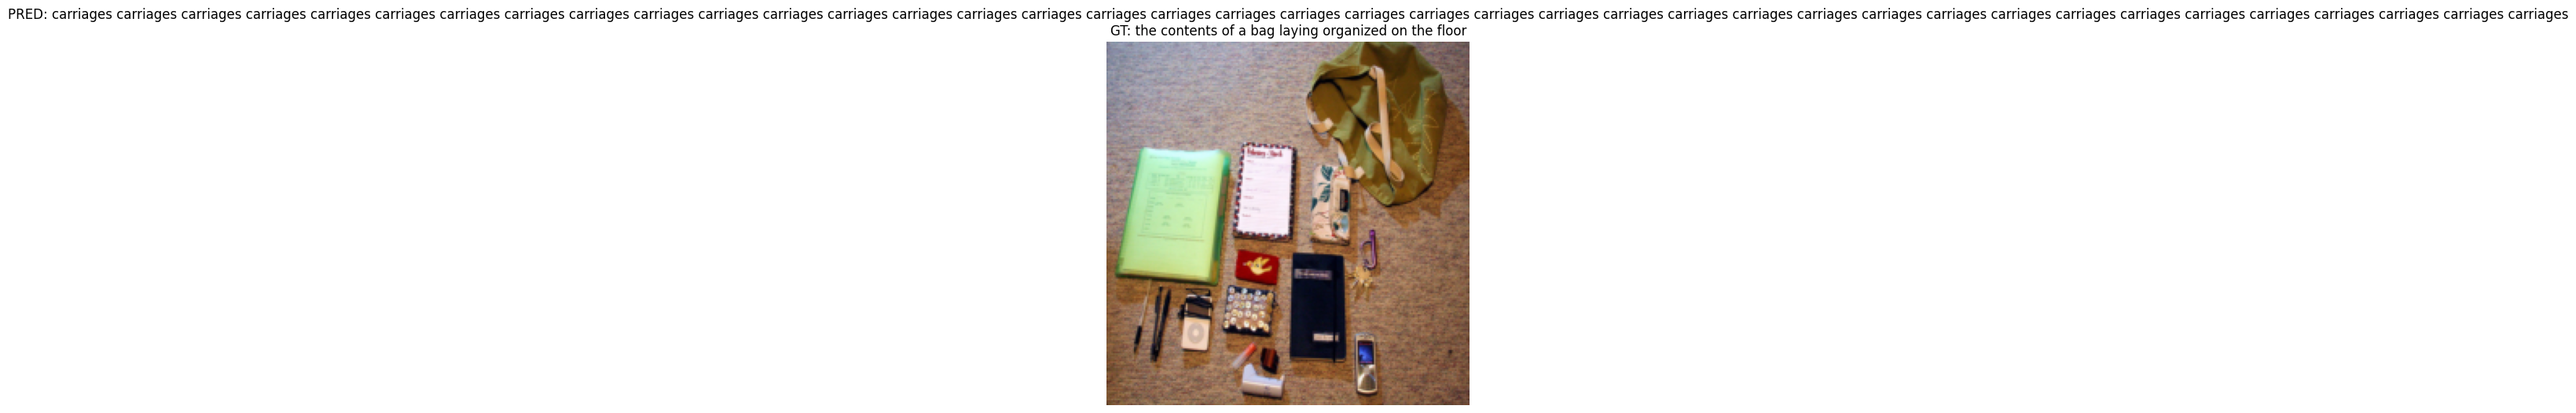

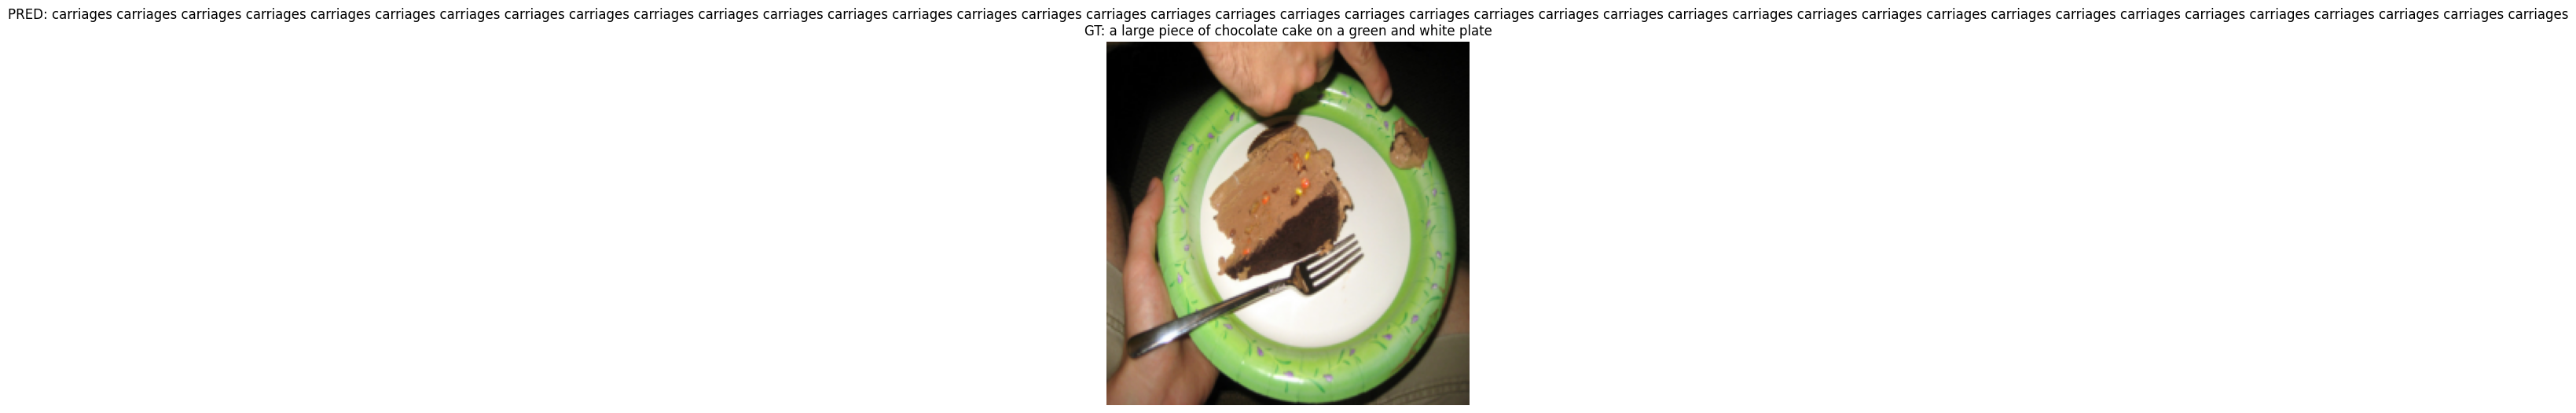

In [25]:
show_samples(model, dataset, tokenizer, num_samples=6, beam=True)

In [26]:
from pycocoevalcap.cider.cider import Cider

def evaluate_cider(model, dataset, tokenizer, num_samples=200, beam=True):
    scorer = Cider()
    gts = {}
    res = {}

    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(tqdm(indices)):
        img, tokens, _ = dataset[idx]

        gt_caption = tokenizer.decode(tokens, skip_special_tokens=True)

        if beam:
            pred_caption = generate_caption_beam(model, img, tokenizer)
        else:
            pred_caption = generate_caption(model, img, tokenizer)

        # CIDEr format
        gts[i] = [gt_caption]
        res[i] = [pred_caption]

    cider_score, _ = scorer.compute_score(gts, res)
    print(f"CIDEr score: {cider_score:.4f}")

In [27]:
evaluate_cider(model, dataset, tokenizer, num_samples=200, beam=True)

100%|██████████| 200/200 [02:24<00:00,  1.38it/s]

CIDEr score: 0.0000
